# Chicago Vehicle Saftey: 
## Traffic Accident Injury Detection & Reduction
Author: Ashli Dougherty
***

# Business Problem
Last year there were 132,967 documented traffic accidents in the city of Chicago. Approximately 20% of all accidents resulted in one or more people injured for a total of 26,593 injuries. The Chicago Department of Transportation is currently working together with [Vision Zero](https://www.chicago.gov/city/en/depts/cdot/supp_info/vision-zero-chicago.html) on a plan to eliminate **ALL** injuries and fatalities whether your mode of transportation is your personal vehicle, public transit, cycling or walking. 

As a partner with these two institutions I used historical crash data in order to make our city a safer place for all those who live, work, and vacation here. My approach to this problem was to build a machine learning model that would: 
1. Predict if an injury would be present at an accident site based on a variety of factors.
2. Determine which factors increase the probability of an injury being present. 

The city can then use the identified factors as a starting point for improvements that can increase citizen safety. 
***

# Data
There are three datasets on the City of Chicago's [open data website](https://data.cityofchicago.org/browse?category=Transportation). Based on the site all three data sets are meant to be used in combination with one another. Datasets are very large and were accessed locally in order to bypass Git's Large File Storage systems. All CSVs can be accessed and downloaded from the website.  

I used the following datasets: 
- [Crashes Dataset](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if): Crash data shows information about each traffic crash on city streets within the City of Chicago limits and under the jurisdiction of Chicago Police Department (CPD).
- [Vehicles Dataset](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3): This dataset contains information about vehicles (or units as they are identified in crash reports) involved in a traffic crash.
- [People Dataset](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d): This data contains information about people involved in a crash and if any injuries were sustained.

Only incidents from the calendar year 2021 will be analyzed as it is the last complete year on record. The number of reports is less than 2018 and 2019 but more than 2020 which indicates that people are driving/using transportation more since the pandemic. 

***

# Data Cleaning

## Setting Up Imports

In [1297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [1298]:
crashes = pd.read_csv('../CarCrashData/Traffic_Crashes_Crashes.csv')
crashes.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,JF318029,NaN,07/15/2022 12:45:00 AM,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,...,0.0,0.0,2.0,0.0,0,6,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761)
1,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,JF324552,NaN,07/15/2022 06:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,18,6,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832)
2,01aaa759c6bbefd0f584226fbd88bdc549de3ed1e46255...,JF319819,NaN,07/15/2022 05:10:00 PM,40,NO CONTROLS,NO CONTROLS,CLOUDY/OVERCAST,DAYLIGHT,ANGLE,...,0.0,0.0,2.0,0.0,17,6,7,41.975826,-87.650420,POINT (-87.650419778017 41.975826016449)
3,0362b3f8ddb8589dfe889356efbc2ad213efe2031556f0...,JF318271,NaN,07/15/2022 08:44:00 AM,30,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,REAR END,...,0.0,0.0,3.0,0.0,8,6,7,41.944199,-87.747157,POINT (-87.747157281564 41.944198992304)
4,03d3679ef44bb8aa0f2060cb0376f3eeb1d9dbb2197322...,JF318956,NaN,07/15/2022 04:10:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,PEDESTRIAN,...,1.0,0.0,1.0,0.0,16,6,7,41.855974,-87.663860,POINT (-87.663860117648 41.855973928536)


In [1299]:
crashes.shape

(643075, 49)

In [1300]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643075 entries, 0 to 643074
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                643075 non-null  object 
 1   RD_NO                          639096 non-null  object 
 2   CRASH_DATE_EST_I               48816 non-null   object 
 3   CRASH_DATE                     643075 non-null  object 
 4   POSTED_SPEED_LIMIT             643075 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         643075 non-null  object 
 6   DEVICE_CONDITION               643075 non-null  object 
 7   WEATHER_CONDITION              643075 non-null  object 
 8   LIGHTING_CONDITION             643075 non-null  object 
 9   FIRST_CRASH_TYPE               643075 non-null  object 
 10  TRAFFICWAY_TYPE                643075 non-null  object 
 11  LANE_CNT                       198990 non-null  float64
 12  ALIGNMENT                     

### Dropping columns with high null counts

In [1301]:
percent_missing = crashes.isnull().sum() * 100 / len(crashes)
crashes_null_values = pd.DataFrame({'column_name': crashes.columns,
                                    'percent_missing': percent_missing})
crashes_null_values.sort_values(by='percent_missing', ascending=False)

,column_name,percent_missing
WORKERS_PRESENT_I,WORKERS_PRESENT_I,99.848851
DOORING_I,DOORING_I,99.686973
WORK_ZONE_TYPE,WORK_ZONE_TYPE,99.533180
WORK_ZONE_I,WORK_ZONE_I,99.405202
PHOTOS_TAKEN_I,PHOTOS_TAKEN_I,98.769506
STATEMENTS_TAKEN_I,STATEMENTS_TAKEN_I,97.947673
NOT_RIGHT_OF_WAY_I,NOT_RIGHT_OF_WAY_I,95.288730
CRASH_DATE_EST_I,CRASH_DATE_EST_I,92.408973
INTERSECTION_RELATED_I,INTERSECTION_RELATED_I,77.123975
HIT_AND_RUN_I,HIT_AND_RUN_I,69.206858


In [1302]:
#columns with high null values (>70%) will be dropped.
#WORKERS_PRESENT_I
#DOORING_I
#WORK_ZONE_TYPE
#WORK_ZONE_I
#PHOTOS_TAKEN_I
#STATEMENTS_TAKEN_I
#NOT_RIGHT_OF_WAY_I
#CRASH_DATE_EST_I
#INTERSECTION_RELATED_I

In [1303]:
crashes.drop(columns = ['WORKERS_PRESENT_I', 'DOORING_I','WORK_ZONE_TYPE',
                        'WORK_ZONE_I','PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 
                        'NOT_RIGHT_OF_WAY_I', 'CRASH_DATE_EST_I', 'INTERSECTION_RELATED_I'],
             inplace=True)

In [1304]:
crashes.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,JF318029,07/15/2022 12:45:00 AM,30,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,...,0.0,0.0,2.0,0.0,0,6,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761)
1,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,JF324552,07/15/2022 06:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,...,0.0,0.0,2.0,0.0,18,6,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832)
2,01aaa759c6bbefd0f584226fbd88bdc549de3ed1e46255...,JF319819,07/15/2022 05:10:00 PM,40,NO CONTROLS,NO CONTROLS,CLOUDY/OVERCAST,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN BARRIER,...,0.0,0.0,2.0,0.0,17,6,7,41.975826,-87.650420,POINT (-87.650419778017 41.975826016449)
3,0362b3f8ddb8589dfe889356efbc2ad213efe2031556f0...,JF318271,07/15/2022 08:44:00 AM,30,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,3.0,0.0,8,6,7,41.944199,-87.747157,POINT (-87.747157281564 41.944198992304)
4,03d3679ef44bb8aa0f2060cb0376f3eeb1d9dbb2197322...,JF318956,07/15/2022 04:10:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,PEDESTRIAN,FOUR WAY,...,1.0,0.0,1.0,0.0,16,6,7,41.855974,-87.663860,POINT (-87.663860117648 41.855973928536)


In [1305]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643075 entries, 0 to 643074
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                643075 non-null  object 
 1   RD_NO                          639096 non-null  object 
 2   CRASH_DATE                     643075 non-null  object 
 3   POSTED_SPEED_LIMIT             643075 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         643075 non-null  object 
 5   DEVICE_CONDITION               643075 non-null  object 
 6   WEATHER_CONDITION              643075 non-null  object 
 7   LIGHTING_CONDITION             643075 non-null  object 
 8   FIRST_CRASH_TYPE               643075 non-null  object 
 9   TRAFFICWAY_TYPE                643075 non-null  object 
 10  LANE_CNT                       198990 non-null  float64
 11  ALIGNMENT                      643075 non-null  object 
 12  ROADWAY_SURFACE_COND          

In [1306]:
crashes.CRASH_DATE.min()

'01/01/2016 01:00:00 AM'

In [1307]:
crashes.CRASH_DATE.max()

'12/31/2021 12:50:00 AM'

In [1308]:
crashes['YEAR'] = crashes.CRASH_DATE.str[6:10]

In [1309]:
crashes.YEAR.value_counts()

2018    118950
2019    117762
2021    108751
2020     92088
2017     83786
2022     67605
2016     44297
2015      9828
2014         6
2013         2
Name: YEAR, dtype: int64

In [1331]:
crashes.YEAR.value_counts()

2018    118950
2019    117762
2021    108751
2020     92088
2017     83786
2022     67605
2016     44297
2015      9828
2014         6
2013         2
Name: YEAR, dtype: int64

In [1321]:
crashes.YEAR.value_counts().index.sort_values()

Index(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022'],
      dtype='object')

In [1336]:
year_dict = {
    2015: 9_828,
    2016: 44_297,
    2017: 83_786,
    2018: 118_950,
    2019: 117_762,
    2020: 92_088,
    2021: 108_751,
    2022: 67_605 
}

year_keys = list(year_dict.keys())
year_values = list(year_dict.values())

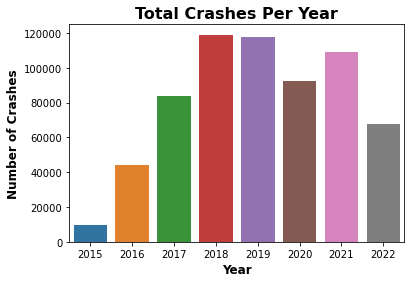

In [1340]:
sns.barplot(x =year_keys, y=year_values)
plt.title("Total Crashes Per Year", weight='bold', size=16)
plt.xlabel("Year", weight='bold', size=12),
plt.ylabel("Number of Crashes", weight='bold', size=12);

In [990]:
crashes = crashes[crashes.YEAR == '2021']

I will only be keeping records from 2021 as it is representative of a complete calendar year and is relatively 'post' pandemic and travel has seemed to resume close to prepandimic levels (such as years 2018 and 2019)

In [991]:
crashes.YEAR.value_counts()

2021    108751
Name: YEAR, dtype: int64

### Dropping Irrelavant Columns 
We want to keep columns that will help us predict the causes of an accident. This decision was based the description of the columns from the City of Chicago website.

In [992]:
crash_rc = [
    'CRASH_RECORD_ID', 
    'CRASH_DATE', 
    'POSTED_SPEED_LIMIT', 
    'DEVICE_CONDITION', 
    'WEATHER_CONDITION', 
    'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE',
    'TRAFFICWAY_TYPE',
    'ALIGNMENT',
    'ROADWAY_SURFACE_COND',
    'ROAD_DEFECT',
    'PRIM_CONTRIBUTORY_CAUSE',
    'SEC_CONTRIBUTORY_CAUSE',
    'INJURIES_TOTAL',
    'INJURIES_FATAL',
    'CRASH_HOUR', 
    'CRASH_DAY_OF_WEEK',
    'CRASH_MONTH',
    'LATITUDE',
    'LONGITUDE']
crashes = crashes[crash_rc]

In [993]:
crashes.head()

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
114,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,07/06/2021 06:55:00 PM,15,UNKNOWN,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,STRAIGHT AND LEVEL,DRY,UNKNOWN,IMPROPER BACKING,UNABLE TO DETERMINE,0.0,0.0,18,3,7,41.929653,-87.675293
754,01a754e24e2a7cf3611047bc08cefa0d5dcf150e2dab2d...,12/10/2021 01:55:00 PM,20,NO CONTROLS,CLOUDY/OVERCAST,DAYLIGHT,PARKED MOTOR VEHICLE,OTHER,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNABLE TO DETERMINE,NOT APPLICABLE,0.0,0.0,13,6,12,NaN,NaN
1683,be7c69045cc5edb1afd241bc875b3faca3040b4a8d63d8...,12/04/2021 11:25:00 AM,30,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,OTHER,STRAIGHT AND LEVEL,DRY,NO DEFECTS,IMPROPER TURNING/NO SIGNAL,UNABLE TO DETERMINE,0.0,0.0,11,7,12,41.831159,-87.622736
5225,0cac79ac951b6f22a578745df1ef93fa63ccca2bca0fc4...,02/21/2021 02:50:00 PM,30,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,OTHER,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNABLE TO DETERMINE,NOT APPLICABLE,0.0,0.0,14,1,2,NaN,NaN
5777,0d624771ccf0949ed8a5607f3b6c27d9b68364ab9fd8ad...,12/24/2021 12:30:00 PM,30,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,FOLLOWING TOO CLOSELY,NOT APPLICABLE,0.0,0.0,12,6,12,NaN,NaN


In [994]:
crashes.shape

(108751, 20)

In [995]:
crashes['CRASH_DATE']

114       07/06/2021 06:55:00 PM
754       12/10/2021 01:55:00 PM
1683      12/04/2021 11:25:00 AM
5225      02/21/2021 02:50:00 PM
5777      12/24/2021 12:30:00 PM
                   ...          
643012    06/15/2021 03:42:00 PM
643017    03/01/2021 11:22:00 AM
643019    04/06/2021 02:30:00 PM
643021    01/13/2021 09:00:00 PM
643023    08/18/2021 09:25:00 AM
Name: CRASH_DATE, Length: 108751, dtype: object

***

### Vehicle Dataset

In [996]:
vehicles = pd.read_csv('../CarCrashData/Traffic_Crashes_Vehicles.csv', low_memory=False)
vehicles.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,JD124535,01/22/2020 06:25:00 AM,1,DRIVER,NaN,796949.0,NaN,INFINITI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,1,DRIVER,NaN,834816.0,NaN,HONDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,749949,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,2,PARKED,NaN,834819.0,NaN,TOYOTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,749950,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,3,PARKED,NaN,834817.0,NaN,GENERAL MOTORS CORPORATION (GMC),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,871921,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,04/13/2020 10:50:00 PM,2,DRIVER,NaN,827212.0,NaN,BUICK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [997]:
vehicles.shape

(1310508, 72)

In [998]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310508 entries, 0 to 1310507
Data columns (total 72 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CRASH_UNIT_ID             1310508 non-null  int64  
 1   CRASH_RECORD_ID           1310508 non-null  object 
 2   RD_NO                     1302413 non-null  object 
 3   CRASH_DATE                1310508 non-null  object 
 4   UNIT_NO                   1310508 non-null  int64  
 5   UNIT_TYPE                 1308666 non-null  object 
 6   NUM_PASSENGERS            194875 non-null   float64
 7   VEHICLE_ID                1280912 non-null  float64
 8   CMRC_VEH_I                24428 non-null    object 
 9   MAKE                      1280907 non-null  object 
 10  MODEL                     1280763 non-null  object 
 11  LIC_PLATE_STATE           1165456 non-null  object 
 12  VEHICLE_YEAR              1072167 non-null  float64
 13  VEHICLE_DEFECT            1

In [999]:
vehicles.describe()

,CRASH_UNIT_ID,UNIT_NO,NUM_PASSENGERS,VEHICLE_ID,VEHICLE_YEAR,OCCUPANT_CNT,CMV_ID,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT
count,1.310508e+06,1.310508e+06,194875.000000,1.280912e+06,1.072167e+06,1.280912e+06,13755.000000,2096.000000,58.000000,2547.000000,3738.000000
mean,7.004904e+05,4.446720e+00,1.471174,6.664611e+05,2.013581e+03,1.079832e+00,7676.348964,48.527195,44.517241,53.125245,10.701980
std,4.064380e+05,3.300243e+03,1.049482,3.844537e+05,1.440080e+02,7.843180e-01,4453.821184,21.564827,28.649265,32.022755,425.355581
min,2.000000e+00,0.000000e+00,1.000000,2.000000e+00,1.900000e+03,0.000000e+00,1.000000,1.000000,2.000000,1.000000,1.000000
25%,3.470888e+05,1.000000e+00,1.000000,3.338198e+05,2.006000e+03,1.000000e+00,3799.500000,45.000000,24.250000,35.000000,2.000000
50%,7.016955e+05,2.000000e+00,1.000000,6.669690e+05,2.012000e+03,1.000000e+00,7695.000000,53.000000,48.000000,53.000000,3.000000
75%,1.053070e+06,2.000000e+00,2.000000,9.989482e+05,2.016000e+03,1.000000e+00,11549.500000,53.000000,53.000000,65.000000,5.000000
max,1.403472e+06,3.778035e+06,59.000000,1.333658e+06,9.999000e+03,9.900000e+01,15365.000000,740.000000,123.000000,999.000000,26009.000000


### Dropping Columns with high null values

In [1000]:
percent_missing2 = vehicles.isnull().sum() * 100 / len(vehicles)
vehicles_null_values = pd.DataFrame({'column_name': vehicles.columns,'percent_missing': percent_missing2})
vehicles_null_values.sort_values(by='percent_missing', ascending=False)

,column_name,percent_missing
HAZMAT_REPORT_NO,HAZMAT_REPORT_NO,99.999924
MCS_REPORT_NO,MCS_REPORT_NO,99.999542
HAZMAT_NAME,HAZMAT_NAME,99.996108
TRAILER2_LENGTH,TRAILER2_LENGTH,99.995574
WIDE_LOAD_I,WIDE_LOAD_I,99.990767
...,...,...
UNIT_TYPE,UNIT_TYPE,0.140556
CRASH_RECORD_ID,CRASH_RECORD_ID,0.000000
UNIT_NO,UNIT_NO,0.000000
CRASH_DATE,CRASH_DATE,0.000000


In [1001]:
relevant_columns = [    
 'CRASH_UNIT_ID',
 'CRASH_RECORD_ID',    
 'RD_NO',  
 'CRASH_DATE',  
 'UNIT_NO',    
 'UNIT_TYPE',    
 'VEHICLE_ID', 
 'MAKE',
 'MODEL',
 'LIC_PLATE_STATE',
 'VEHICLE_YEAR',
 'VEHICLE_DEFECT',
 'VEHICLE_TYPE',
 'VEHICLE_USE',
 'TRAVEL_DIRECTION',
 'MANEUVER',
 'OCCUPANT_CNT',
 'FIRST_CONTACT_POINT',
]
vehicles = vehicles[relevant_columns]

In [1002]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310508 entries, 0 to 1310507
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   CRASH_UNIT_ID        1310508 non-null  int64  
 1   CRASH_RECORD_ID      1310508 non-null  object 
 2   RD_NO                1302413 non-null  object 
 3   CRASH_DATE           1310508 non-null  object 
 4   UNIT_NO              1310508 non-null  int64  
 5   UNIT_TYPE            1308666 non-null  object 
 6   VEHICLE_ID           1280912 non-null  float64
 7   MAKE                 1280907 non-null  object 
 8   MODEL                1280763 non-null  object 
 9   LIC_PLATE_STATE      1165456 non-null  object 
 10  VEHICLE_YEAR         1072167 non-null  float64
 11  VEHICLE_DEFECT       1280912 non-null  object 
 12  VEHICLE_TYPE         1280912 non-null  object 
 13  VEHICLE_USE          1280912 non-null  object 
 14  TRAVEL_DIRECTION     1280912 non-null  object 
 15

In [1003]:
#columns dropped had more than 70% missing values

Same as crashes, will only be keeping records for year 2021.

In [1004]:
vehicles['YEAR'] = vehicles.CRASH_DATE.str[6:10]

In [1005]:
vehicles = vehicles[vehicles.YEAR == '2021']

In [1006]:
vehicles['YEAR'].value_counts() 

2021    222414
Name: YEAR, dtype: int64

### Dropping Irrelevant Columns 

In [1007]:
vehicle_rc = [
    'CRASH_UNIT_ID',
    'CRASH_RECORD_ID',
    'CRASH_DATE',
    'UNIT_NO',
    'UNIT_TYPE',
    'VEHICLE_ID',
    'MAKE',
    'MODEL',
    'LIC_PLATE_STATE',
    'VEHICLE_YEAR',
    'VEHICLE_DEFECT',
    'VEHICLE_TYPE',
    'VEHICLE_USE',
    'TRAVEL_DIRECTION',
    'MANEUVER',
    'OCCUPANT_CNT',
]

vehicles = vehicles[vehicle_rc]

In [1008]:
vehicles.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,VEHICLE_ID,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT
733,1213514,9c52c3670052ee15932f7b6e68c58488308d575207632b...,10/26/2021 03:04:00 PM,1,DRIVER,1151483.0,UNKNOWN,MOTORIZED,NaN,NaN,UNKNOWN,PASSENGER,UNKNOWN/NA,W,STRAIGHT AHEAD,1.0
866,1165440,302a1fe82496e79991dec592178dbb9af59e2b4b44b563...,08/20/2021 07:30:00 AM,1,DRIVER,1105520.0,VOLKSWAGEN,ARTEON,IL,2021.0,NONE,PASSENGER,PERSONAL,W,SLOW/STOP IN TRAFFIC,1.0
1022,1165444,a7377ec23fdc7001e4e75e88d4427f4f225e00b6942100...,08/20/2021 08:15:00 AM,1,DRIVER,1105525.0,TOYOTA,COROLLA,IL,2017.0,NONE,PASSENGER,PERSONAL,SE,STRAIGHT AHEAD,1.0
1066,1165445,a7377ec23fdc7001e4e75e88d4427f4f225e00b6942100...,08/20/2021 08:15:00 AM,2,DRIVER,1105523.0,HONDA,CR-V,IL,2019.0,NONE,PASSENGER,PERSONAL,SE,STRAIGHT AHEAD,1.0
1223,1165450,7ae54d8a4c376515ffcb521e5e392a49da4685170ab8e2...,08/20/2021 08:05:00 AM,1,DRIVER,1105527.0,CHEVROLET,SILVERADO,IL,2003.0,NONE,PICKUP,PERSONAL,S,STRAIGHT AHEAD,1.0


In [1009]:
vehicles.shape

(222414, 16)

***

### People Dataset

In [1010]:
people = pd.read_csv('../CarCrashData/Traffic_Crashes_People.csv', low_memory = False)
people.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,HY484534,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,...,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,HY484750,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,HY484778,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


In [1011]:
people.shape

(1411302, 30)

In [1012]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411302 entries, 0 to 1411301
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              1411302 non-null  object 
 1   PERSON_TYPE            1411302 non-null  object 
 2   CRASH_RECORD_ID        1411302 non-null  object 
 3   RD_NO                  1402786 non-null  object 
 4   VEHICLE_ID             1383689 non-null  float64
 5   CRASH_DATE             1411302 non-null  object 
 6   SEAT_NO                286695 non-null   float64
 7   CITY                   1032365 non-null  object 
 8   STATE                  1045620 non-null  object 
 9   ZIPCODE                943216 non-null   object 
 10  SEX                    1389569 non-null  object 
 11  AGE                    1002324 non-null  float64
 12  DRIVERS_LICENSE_STATE  830404 non-null   object 
 13  DRIVERS_LICENSE_CLASS  706269 non-null   object 
 14  SAFETY_EQUIPMENT  

In [1013]:
people.describe()

,VEHICLE_ID,SEAT_NO,AGE,BAC_RESULT VALUE
count,1.383689e+06,286695.000000,1.002324e+06,1726.000000
mean,6.615749e+05,4.160526,3.780826e+01,0.168662
std,3.832647e+05,2.196837,1.710068e+01,0.102762
min,2.000000e+00,1.000000,-1.770000e+02,0.000000
25%,3.317300e+05,3.000000,2.500000e+01,0.120000
50%,6.573470e+05,3.000000,3.500000e+01,0.170000
75%,9.928570e+05,5.000000,5.000000e+01,0.217500
max,1.333658e+06,12.000000,1.100000e+02,1.000000


### Dropping columns with high null values

In [1014]:
percent_missing3 = people.isnull().sum() * 100 / len(people)
people_null_values = pd.DataFrame({'column_name': people.columns,'percent_missing': percent_missing3})
people_null_values.sort_values(by='percent_missing', ascending=False)

,column_name,percent_missing
CELL_PHONE_USE,CELL_PHONE_USE,99.918019
BAC_RESULT VALUE,BAC_RESULT VALUE,99.877702
EMS_RUN_NO,EMS_RUN_NO,98.207754
PEDPEDAL_VISIBILITY,PEDPEDAL_VISIBILITY,98.154470
PEDPEDAL_LOCATION,PEDPEDAL_LOCATION,98.150927
PEDPEDAL_ACTION,PEDPEDAL_ACTION,98.150715
EMS_AGENCY,EMS_AGENCY,89.067684
HOSPITAL,HOSPITAL,82.497651
SEAT_NO,SEAT_NO,79.685780
DRIVERS_LICENSE_CLASS,DRIVERS_LICENSE_CLASS,49.956211


In [1015]:
people.drop(columns = ['CELL_PHONE_USE', 'BAC_RESULT VALUE','EMS_RUN_NO',
                      'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'PEDPEDAL_ACTION',
                      'EMS_AGENCY', 'HOSPITAL', 'SEAT_NO'],
             inplace=True)

In [1016]:
people.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,CITY,STATE,ZIPCODE,SEX,...,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,BAC_RESULT
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,834816.0,09/28/2019 03:30:00 AM,CHICAGO,IL,60651,M,...,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,827212.0,04/13/2020 10:50:00 PM,CHICAGO,IL,60620,M,...,IL,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NONE,NOT OBSCURED,NORMAL,TEST NOT OFFERED
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,HY484534,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,X,...,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,IMPROPER BACKING,UNKNOWN,UNKNOWN,TEST NOT OFFERED
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,HY484750,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,X,...,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,HY484778,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,X,...,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED


In [1017]:
# all dropped columns were missing more than 70% of data

Again, only keeping rows from year 2021.

In [1018]:
people['YEAR'] = people.CRASH_DATE.str[6:10]

In [1019]:
people = people[people.YEAR == '2021']

In [1020]:
people['YEAR'].value_counts() 

2021    233757
Name: YEAR, dtype: int64

In [1021]:
people.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,CITY,STATE,ZIPCODE,SEX,...,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,BAC_RESULT,YEAR
10604,O1094328,DRIVER,dccd19b99ed730f6fbd6788f9720c421411e61686b68c2...,JE228278,1037948.0,05/12/2021 04:00:00 PM,BLOOMINGTON,IL,60701,F,...,NaN,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED,2021
21035,O1094329,DRIVER,dccd19b99ed730f6fbd6788f9720c421411e61686b68c2...,JE228278,1037954.0,05/12/2021 04:00:00 PM,CHICAGO,IL,60617,F,...,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,NORMAL,TEST NOT OFFERED,2021
33144,O1233469,DRIVER,24366036b48debddfe4274f8415c19fdb160dcbd704c63...,JE455604,1170625.0,11/24/2021 11:36:00 AM,CHICAGO,IL,60643,M,...,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,OTHER,NOT OBSCURED,NORMAL,TEST NOT OFFERED,2021
47127,O1233470,DRIVER,24366036b48debddfe4274f8415c19fdb160dcbd704c63...,JE455604,1170622.0,11/24/2021 11:36:00 AM,SHOREWOOD,IL,60404,F,...,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NONE,NOT OBSCURED,NORMAL,TEST NOT OFFERED,2021
94039,O1119948,DRIVER,dabd1660ae1201641d053c59e4672d9295f05812015a55...,JE269246,1062297.0,06/17/2021 12:00:00 PM,NaN,NaN,NaN,X,...,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED,2021


In [1022]:
people.shape

(233757, 22)

### Dropping Irrelevant Columns

In [1023]:
people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233757 entries, 10604 to 1411215
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   PERSON_ID              233757 non-null  object 
 1   PERSON_TYPE            233757 non-null  object 
 2   CRASH_RECORD_ID        233757 non-null  object 
 3   RD_NO                  233757 non-null  object 
 4   VEHICLE_ID             229459 non-null  float64
 5   CRASH_DATE             233757 non-null  object 
 6   CITY                   164645 non-null  object 
 7   STATE                  167525 non-null  object 
 8   ZIPCODE                149992 non-null  object 
 9   SEX                    229859 non-null  object 
 10  AGE                    161635 non-null  float64
 11  DRIVERS_LICENSE_STATE  133446 non-null  object 
 12  DRIVERS_LICENSE_CLASS  106818 non-null  object 
 13  SAFETY_EQUIPMENT       233160 non-null  object 
 14  AIRBAG_DEPLOYED        229621 n

In [1024]:
people_rc = [
    'PERSON_ID',
    'PERSON_TYPE',
    'CRASH_RECORD_ID',
    'VEHICLE_ID',
    'CRASH_DATE',
    'CITY',
    'STATE',
    'ZIPCODE',
    'SEX',
    'AGE',
    'DRIVERS_LICENSE_STATE',
    'DRIVERS_LICENSE_CLASS',
    'SAFETY_EQUIPMENT',
    'AIRBAG_DEPLOYED',
    'INJURY_CLASSIFICATION',
    'DRIVER_ACTION',
    'DRIVER_VISION',
    'PHYSICAL_CONDITION',
]

people = people[people_rc]

In [1025]:
people.shape

(233757, 18)

***

##  Combining the Data

As stated by the City of Chicago's website, the three datasets should be used in conjunction with one another. Therefore I will need to merge them into one data frame. **Crash Record ID** is a consistent identifier for each table and will be merged on this column.
- **Crash Record ID:** This number can be used to link to the same crash in the Crashes and Vehicles datasets. This number also serves as a unique ID in the Crashes dataset.
 

In [1026]:
merged1 = pd.merge(left=crashes, right=vehicles, on='CRASH_RECORD_ID')

In [1027]:
merged1.head()

,CRASH_RECORD_ID,CRASH_DATE_x,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,...,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT
0,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,07/06/2021 06:55:00 PM,15,UNKNOWN,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,STRAIGHT AND LEVEL,DRY,...,LEXUS,RX350,IL,2011.0,UNKNOWN,PASSENGER,PERSONAL,UNKNOWN,BACKING,2.0
1,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,07/06/2021 06:55:00 PM,15,UNKNOWN,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,STRAIGHT AND LEVEL,DRY,...,HYUNDAI,TUCSON,IL,2020.0,UNKNOWN,PASSENGER,PERSONAL,UNKNOWN,STRAIGHT AHEAD,1.0
2,01a754e24e2a7cf3611047bc08cefa0d5dcf150e2dab2d...,12/10/2021 01:55:00 PM,20,NO CONTROLS,CLOUDY/OVERCAST,DAYLIGHT,PARKED MOTOR VEHICLE,OTHER,STRAIGHT AND LEVEL,DRY,...,FORD,OTHER (EXPLAIN IN NARRATIVE),IL,2007.0,UNKNOWN,OTHER,OTHER,E,PASSING/OVERTAKING,1.0
3,01a754e24e2a7cf3611047bc08cefa0d5dcf150e2dab2d...,12/10/2021 01:55:00 PM,20,NO CONTROLS,CLOUDY/OVERCAST,DAYLIGHT,PARKED MOTOR VEHICLE,OTHER,STRAIGHT AND LEVEL,DRY,...,MERCEDES-BENZ,ML450,IL,2015.0,UNKNOWN,PASSENGER,PERSONAL,E,PARKED IN TRAFFIC LANE,0.0
4,be7c69045cc5edb1afd241bc875b3faca3040b4a8d63d8...,12/04/2021 11:25:00 AM,30,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,OTHER,STRAIGHT AND LEVEL,DRY,...,HONDA,OTHER (EXPLAIN IN NARRATIVE),IL,2016.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,1.0


In [1028]:
merged1.shape

(222414, 35)

### merging with people

In [1029]:
merged2 = pd.merge(left=merged1, right=people, on='CRASH_RECORD_ID')

In [1030]:
merged2.shape

(492019, 52)

In [1031]:
merged2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492019 entries, 0 to 492018
Data columns (total 52 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          492019 non-null  object 
 1   CRASH_DATE_x             492019 non-null  object 
 2   POSTED_SPEED_LIMIT       492019 non-null  int64  
 3   DEVICE_CONDITION         492019 non-null  object 
 4   WEATHER_CONDITION        492019 non-null  object 
 5   LIGHTING_CONDITION       492019 non-null  object 
 6   FIRST_CRASH_TYPE         492019 non-null  object 
 7   TRAFFICWAY_TYPE          492019 non-null  object 
 8   ALIGNMENT                492019 non-null  object 
 9   ROADWAY_SURFACE_COND     492019 non-null  object 
 10  ROAD_DEFECT              492019 non-null  object 
 11  PRIM_CONTRIBUTORY_CAUSE  492019 non-null  object 
 12  SEC_CONTRIBUTORY_CAUSE   492019 non-null  object 
 13  INJURIES_TOTAL           492019 non-null  float64
 14  INJU

In [1032]:
# dropping duplicate columns

In [1033]:
merged2.drop(columns=['CRASH_DATE','CRASH_DATE_x', 'CRASH_DATE_y',
                      'VEHICLE_ID_x','VEHICLE_ID_y'], inplace=True)

In [1034]:
merged2.shape

(492019, 47)

There are still too many features and several will need to be binned (age, time of day, weather...).
The problem I am addressing is "how to decrease injuries" so certain features may still be irrelevant. Based on further research I will also drop the following columns: 
- **ALIGNMENT**: 97% were straight and level
- **ROAD_DEFECT**: 83% were none and 15% unknown
- **SEC_CONTRIBUTORY_CAUSE**: 73% were n/a or unable to determine
- **MAKE**: maker of car not relevant
- **MODEL**: model of car not relevant 
- **LIC_PLATE_STATE**: 91% from IL, not relevant
- **VEHICLE_DEFECT**: 98% either none or unknown
- **TRAVEL_DIRECTION**: entered by officer, not relevant
- **PERSON_ID**: not relevant, record is captured by CRASH_ID
- **CITY**: not relevant as it refers to where the people lived, all crashes occured in Chicago
- **STATE**: not relevant as it refers to where the people lived, all crashes occured in Chicago
- **ZIPCODE**: not relevant as it refers to where the people lived, all crashes occured in Chicago
- **DRIVERS_LICENSE_STATE**: not relevant as it refers to where the people lived, all crashes occured in Chicago
- **DRIVERS_LICENSE_CLASS**: not relevant as it refers to where the people lived, all crashes occured in Chicago
- **INJURY_CLASSIFICATION**: redundant
- **DRIVER_ACTION**: subjective, reported by officer
- **VEHICLE_ID**: not relevant, record is captured by CRASH_ID
- **PHYSICAL_CONDITION**: 91% none or unknown
- **PRIM_CONTRIBUTORY_CAUSE**: subjective, given by officer
- **LATITUDE** & **LONGITUDE**: numbers are all very similar

In [1035]:
merged2.drop(columns=[
    'ALIGNMENT', 'ROAD_DEFECT', 'SEC_CONTRIBUTORY_CAUSE', 'MAKE', 'MODEL',
    'LIC_PLATE_STATE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION', 'PERSON_ID', 'CITY', 'STATE',
    'ZIPCODE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'INJURY_CLASSIFICATION', 
    'DRIVER_ACTION', 'PHYSICAL_CONDITION', 'PRIM_CONTRIBUTORY_CAUSE', 'CRASH_UNIT_ID'
], inplace=True)

In [1036]:
merged2.shape

(492019, 28)

In [1037]:
#checking nulls after combining

In [1038]:
merged2.isna().sum()

CRASH_RECORD_ID              0
POSTED_SPEED_LIMIT           0
DEVICE_CONDITION             0
WEATHER_CONDITION            0
LIGHTING_CONDITION           0
FIRST_CRASH_TYPE             0
TRAFFICWAY_TYPE              0
ROADWAY_SURFACE_COND         0
INJURIES_TOTAL               0
INJURIES_FATAL               0
CRASH_HOUR                   0
CRASH_DAY_OF_WEEK            0
CRASH_MONTH                  0
LATITUDE                  3611
LONGITUDE                 3611
UNIT_NO                      0
UNIT_TYPE                  489
VEHICLE_YEAR             80152
VEHICLE_TYPE             10274
VEHICLE_USE              10274
MANEUVER                 10274
OCCUPANT_CNT             10274
PERSON_TYPE                  0
SEX                       8434
AGE                     150722
SAFETY_EQUIPMENT          1349
AIRBAG_DEPLOYED           8804
DRIVER_VISION           100432
dtype: int64

In [1039]:
#due to size of data set all null values will be dropped

In [1040]:
merged2.dropna(inplace=True)

In [1041]:
merged2.isna().sum()

CRASH_RECORD_ID         0
POSTED_SPEED_LIMIT      0
DEVICE_CONDITION        0
WEATHER_CONDITION       0
LIGHTING_CONDITION      0
FIRST_CRASH_TYPE        0
TRAFFICWAY_TYPE         0
ROADWAY_SURFACE_COND    0
INJURIES_TOTAL          0
INJURIES_FATAL          0
CRASH_HOUR              0
CRASH_DAY_OF_WEEK       0
CRASH_MONTH             0
LATITUDE                0
LONGITUDE               0
UNIT_NO                 0
UNIT_TYPE               0
VEHICLE_YEAR            0
VEHICLE_TYPE            0
VEHICLE_USE             0
MANEUVER                0
OCCUPANT_CNT            0
PERSON_TYPE             0
SEX                     0
AGE                     0
SAFETY_EQUIPMENT        0
AIRBAG_DEPLOYED         0
DRIVER_VISION           0
dtype: int64

In [1042]:
merged2.reset_index(drop=True)

,CRASH_RECORD_ID,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,INJURIES_TOTAL,INJURIES_FATAL,...,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,OCCUPANT_CNT,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,DRIVER_VISION
0,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,15,UNKNOWN,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,DRY,0.0,0.0,...,PASSENGER,PERSONAL,BACKING,2.0,DRIVER,F,62.0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
1,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,15,UNKNOWN,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,DRY,0.0,0.0,...,PASSENGER,PERSONAL,BACKING,2.0,DRIVER,F,26.0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
2,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,15,UNKNOWN,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,DRY,0.0,0.0,...,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.0,DRIVER,F,62.0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
3,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,15,UNKNOWN,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,DRY,0.0,0.0,...,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.0,DRIVER,F,26.0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
4,be7c69045cc5edb1afd241bc875b3faca3040b4a8d63d8...,30,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,OTHER,DRY,0.0,0.0,...,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.0,DRIVER,F,32.0,USAGE UNKNOWN,NOT APPLICABLE,NOT OBSCURED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241689,fe03571ea7c45bff64bddf77d2d840bd069569a11b7d04...,25,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,ONE-WAY,UNKNOWN,0.0,0.0,...,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.0,DRIVER,M,42.0,SAFETY BELT USED,NOT APPLICABLE,UNKNOWN
241690,fe3fd2ed43d9e96cea4fe8746f3fde81b532dc9929c7fb...,30,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,DRY,0.0,0.0,...,SPORT UTILITY VEHICLE (SUV),PERSONAL,STRAIGHT AHEAD,1.0,DRIVER,M,55.0,SAFETY BELT USED,DID NOT DEPLOY,NOT OBSCURED
241691,fe3fd2ed43d9e96cea4fe8746f3fde81b532dc9929c7fb...,30,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,DRY,0.0,0.0,...,SPORT UTILITY VEHICLE (SUV),PERSONAL,STRAIGHT AHEAD,1.0,DRIVER,M,43.0,SAFETY BELT USED,DID NOT DEPLOY,NOT OBSCURED
241692,fe3fd2ed43d9e96cea4fe8746f3fde81b532dc9929c7fb...,30,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,DRY,0.0,0.0,...,PICKUP,PERSONAL,SLOW/STOP IN TRAFFIC,1.0,DRIVER,M,55.0,SAFETY BELT USED,DID NOT DEPLOY,NOT OBSCURED


### Dropping Duplicate Records

In [1043]:
merged2.duplicated().sum()

744

In [1044]:
merged2.drop_duplicates(keep='first', inplace=True)

In [1045]:
merged2.duplicated().sum()

0

In [1046]:
merged2.shape

(240950, 28)

***

## Binning Data

Several of the columns have a high number of unique entries. For categorical columns especially these values/descriptions will be binned inorder to increase future model efficiancy. 

**Device Condition**

In [1047]:
merged2.DEVICE_CONDITION.value_counts()
#Condition of traffic control device, as determined by reporting officer

NO CONTROLS                 119443
FUNCTIONING PROPERLY        104039
UNKNOWN                      13391
OTHER                         2041
FUNCTIONING IMPROPERLY        1146
NOT FUNCTIONING                794
WORN REFLECTIVE MATERIAL        54
MISSING                         42
Name: DEVICE_CONDITION, dtype: int64

In [1048]:
merged2['DEVICE_CONDITION'] = merged2.DEVICE_CONDITION.map({
    'NO CONTROLS':'Not Working',
    'FUNCTIONING PROPERLY':'Working', 
    'UNKNOWN': 'Unknown',
    'OTHER': 'Unknown',
    'FUNCTIONING IMPROPERLY': 'Not Working',
    'NOT FUNCTIONING': 'Not Working',
    'WORN REFLECTIVE MATERIAL': 'Working',
    'MISSING': 'Unknown' 
})

In [1049]:
merged2.DEVICE_CONDITION.value_counts()

Not Working    121383
Working        104093
Unknown         15474
Name: DEVICE_CONDITION, dtype: int64

In [1050]:
merged2.DEVICE_CONDITION.isna().sum()

0

**Posted Speed Limit**

In [1051]:
merged2.POSTED_SPEED_LIMIT.value_counts()

30    185095
35     18121
25     13425
20      7937
15      5688
10      4054
40      3256
45      1982
5        569
0        338
55       244
50        71
3         65
39        33
34        16
24        14
60        13
9          5
32         4
7          4
33         4
4          3
2          3
1          3
11         2
38         1
Name: POSTED_SPEED_LIMIT, dtype: int64

In [1052]:
speed_bins = [-1, 30, 60, 100]
speed_labels = ['0-30', '30-60', '60-100']

In [1053]:
merged2.POSTED_SPEED_LIMIT = pd.cut(x=merged2.POSTED_SPEED_LIMIT, 
                                    bins= speed_bins,
                                    labels = speed_labels
                                   ,)
                                   

In [1054]:
merged2.POSTED_SPEED_LIMIT.value_counts()

0-30      217205
30-60      23745
60-100         0
Name: POSTED_SPEED_LIMIT, dtype: int64

In [1055]:
merged2.POSTED_SPEED_LIMIT.isna().sum()

0

**Weather Condition**

In [1056]:
merged2.WEATHER_CONDITION.value_counts()

CLEAR                     196134
RAIN                       19505
SNOW                        8550
CLOUDY/OVERCAST             7938
UNKNOWN                     6929
OTHER                        740
FREEZING RAIN/DRIZZLE        571
BLOWING SNOW                 197
SLEET/HAIL                   179
FOG/SMOKE/HAZE               144
SEVERE CROSS WIND GATE        63
Name: WEATHER_CONDITION, dtype: int64

In [1057]:
merged2['WEATHER_CONDITION'] = merged2.WEATHER_CONDITION.map({
    'CLEAR':'Clear',
    'RAIN':'Rain/Sleet/Snow', 
    'SNOW': 'Rain/Sleet/Snow',
    'CLOUDY/OVERCAST': 'Cloudy',
    'UNKNOWN': 'Other/Unknown',
    'OTHER': 'Other/Unknown',
    'FREEZING RAIN/DRIZZLE':'Rain/Sleet/Snow',
    'SLEET/HAIL': 'Rain/Sleet/Snow',
    'FOG/SMOKE/HAZE': 'Fog/Smoke/Haze',
    'BLOWING SNOW':'Rain/Sleet/Snow', 
    'SEVERE CROSS WIND GATE': 'Windy',
    'BLOWING SAND, SOIL, DIRT': 'Windy'
})

In [1058]:
merged2.WEATHER_CONDITION.value_counts()

Clear              196134
Rain/Sleet/Snow     29002
Cloudy               7938
Other/Unknown        7669
Fog/Smoke/Haze        144
Windy                  63
Name: WEATHER_CONDITION, dtype: int64

In [1059]:
merged2.WEATHER_CONDITION.isna().sum()

0

**Lighting Condition**

In [1060]:
merged2.LIGHTING_CONDITION.value_counts()

DAYLIGHT                  163360
DARKNESS, LIGHTED ROAD     54075
DARKNESS                    8417
DUSK                        6925
UNKNOWN                     4378
DAWN                        3795
Name: LIGHTING_CONDITION, dtype: int64

In [1061]:
merged2['LIGHTING_CONDITION'] = merged2.LIGHTING_CONDITION.map({
    'DAYLIGHT':'Day',
    'DARKNESS, LIGHTED ROAD':'Night', 
    'DARKNESS': 'Night',
    'DUSK': 'Night',
    'DAWN': 'Day',
    'UNKNOWN': 'Unknown',

})

In [1062]:
merged2.LIGHTING_CONDITION.value_counts()

Day        167155
Night       69417
Unknown      4378
Name: LIGHTING_CONDITION, dtype: int64

In [1063]:
merged2.LIGHTING_CONDITION.isna().sum()

0

**Crash Type**

In [1064]:
merged2.FIRST_CRASH_TYPE.value_counts()

REAR END                        68508
TURNING                         48623
SIDESWIPE SAME DIRECTION        41602
ANGLE                           38374
PARKED MOTOR VEHICLE            21063
REAR TO FRONT                    4224
FIXED OBJECT                     4194
SIDESWIPE OPPOSITE DIRECTION     4151
HEAD ON                          3223
REAR TO SIDE                     2771
PEDESTRIAN                       1181
REAR TO REAR                      898
PEDALCYCLIST                      894
OTHER OBJECT                      872
OTHER NONCOLLISION                219
OVERTURNED                         90
ANIMAL                             54
TRAIN                               9
Name: FIRST_CRASH_TYPE, dtype: int64

In [1065]:
merged2['FIRST_CRASH_TYPE'] = merged2.FIRST_CRASH_TYPE.map({
    'REAR END':'Rear',
    'TURNING':'Moving', 
    'SIDESWIPE SAME DIRECTION': 'Side',
    'ANGLE': 'Moving',
    'PARKED MOTOR VEHICLE': 'Stationary',
    'SIDESWIPE OPPOSITE DIRECTION': 'Side',
    'FIXED OBJECT':'Object', 
    'HEAD ON': 'Head',
    'REAR TO FRONT': 'Rear',
    'REAR TO SIDE': 'Rear',
    'PEDESTRIAN': 'Person',
    'PEDALCYCLIST': 'Person',
    'OTHER OBJECT':'Object', 
    'REAR TO REAR': 'Rear',
    'OTHER NONCOLLISION': 'Other',
    'OVERTURNED': 'Moving',
    'ANIMAL': 'Object',
    'TRAIN': 'Train'
})

In [1066]:
merged2.FIRST_CRASH_TYPE.value_counts()

Moving        87087
Rear          76401
Side          45753
Stationary    21063
Object         5120
Head           3223
Person         2075
Other           219
Train             9
Name: FIRST_CRASH_TYPE, dtype: int64

In [1067]:
merged2.FIRST_CRASH_TYPE.isna().sum()

0

**Trafficway Type**

In [1068]:
merged2.TRAFFICWAY_TYPE.value_counts()

NOT DIVIDED                        103929
DIVIDED - W/MEDIAN (NOT RAISED)     41274
FOUR WAY                            29662
ONE-WAY                             19214
DIVIDED - W/MEDIAN BARRIER          15384
PARKING LOT                          9696
T-INTERSECTION                       5873
OTHER                                4909
ALLEY                                2505
UNKNOWN                              1971
CENTER TURN LANE                     1799
UNKNOWN INTERSECTION TYPE            1166
FIVE POINT, OR MORE                   700
Y-INTERSECTION                        662
RAMP                                  656
TRAFFIC ROUTE                         555
DRIVEWAY                              504
NOT REPORTED                          295
ROUNDABOUT                            104
L-INTERSECTION                         92
Name: TRAFFICWAY_TYPE, dtype: int64

In [1069]:
merged2['TRAFFICWAY_TYPE'] = merged2.TRAFFICWAY_TYPE.map({
    'NOT DIVIDED': 'Road/Street',
    'DIVIDED - W/MEDIAN (NOT RAISED)': 'Road/Street',
    'ONE-WAY': 'Road/Street',
    'DIVIDED - W/MEDIAN BARRIER': 'Road/Street',
    'FOUR WAY': 'Intersection',
    'PARKING LOT': 'Parking lot',
    'OTHER': "Other/Unknown",
    'T-INTERSECTION': 'Intersection',
    'CENTER TURN LANE': 'Road/Street',
    'ALLEY': 'Road/Street',
    'UNKNOWN': 'Other/Unknown',
    'RAMP': 'Highway',
    'UNKNOWN INTERSECTION TYPE': "Other/Unknown",
    'DRIVEWAY': 'Parking lot',
    'FIVE POINT, OR MORE': 'Intersection',
    'Y-INTERSECTION': 'Intersection',
    'TRAFFIC ROUTE': 'Other/Unknown',
    'NOT REPORTED': 'Other/Unknown',
    'ROUNDABOUT': 'Intersection',
    'L-INTERSECTION': 'Intersection'
})

In [1070]:
merged2.TRAFFICWAY_TYPE.value_counts()

Road/Street      184105
Intersection      37093
Parking lot       10200
Other/Unknown      8896
Highway             656
Name: TRAFFICWAY_TYPE, dtype: int64

In [1071]:
merged2.TRAFFICWAY_TYPE.isna().sum()

0

**Roadway Surface Condition**

In [1072]:
merged2.ROADWAY_SURFACE_COND.value_counts()

DRY                184494
WET                 30691
UNKNOWN             14058
SNOW OR SLUSH        9812
ICE                  1182
OTHER                 672
SAND, MUD, DIRT        41
Name: ROADWAY_SURFACE_COND, dtype: int64

In [1073]:
merged2['ROADWAY_SURFACE_COND'] = merged2.ROADWAY_SURFACE_COND.map({
    'DRY': 'Dry',
    'WET': 'Wet',
    'UNKNOWN': 'Other/Unknown',
    'SNOW OR SLUSH': 'Ice',
    'ICE': 'Ice',
    'OTHER': "Other/Unknown",
    'SAND, MUD, DIRT': "Other/Unknown"
})

In [1074]:
merged2.ROADWAY_SURFACE_COND.value_counts()

Dry              184494
Wet               30691
Other/Unknown     14771
Ice               10994
Name: ROADWAY_SURFACE_COND, dtype: int64

In [1075]:
merged2.CRASH_HOUR.isna().sum()

0

**Crash Hour**

In [1076]:
merged2.CRASH_HOUR.value_counts()

15    20098
16    20082
17    19327
14    17180
13    16110
18    15960
12    14508
11    13224
19    11245
10    10958
8     10869
9     10264
20     8927
7      8278
21     7940
22     7117
23     6034
0      4712
6      4223
1      3997
2      3195
5      2495
3      2291
4      1916
Name: CRASH_HOUR, dtype: int64

In [1077]:
merged2.CRASH_HOUR = pd.cut(x = merged2.CRASH_HOUR,
                                   bins =[-1, 6, 12, 18, 23],
                                   labels = ['Early Morning', 'Morning', 'Afternoon', 'Evening/Night'])

In [1288]:
merged2.CRASH_HOUR.value_counts(normalize=True)

Afternoon        0.427246
Morning          0.293697
Evening/Night    0.175900
Early Morning    0.103157
Name: CRASH_HOUR, dtype: float64

In [1079]:
merged2.CRASH_HOUR.isna().sum()

0

**Unit Number**

A unique ID for each unit within a specific crash report.

In [1080]:
merged2.UNIT_NO.value_counts()

2     115035
1     109823
3      12286
4       2658
5        692
6        262
7        129
8         53
9         11
10         1
Name: UNIT_NO, dtype: int64

In [1081]:
#after looking at value counts, 
#this column is not helpful and will be dropped

In [1082]:
merged2.drop('UNIT_NO', axis =1, inplace=True)

**Unit Type**

In [1083]:
merged2.UNIT_TYPE.value_counts()

DRIVER                 226266
PARKED                  13897
DRIVERLESS                752
DISABLED VEHICLE           22
NON-CONTACT VEHICLE        13
Name: UNIT_TYPE, dtype: int64

In [1084]:
merged2.drop('UNIT_TYPE', axis =1, inplace=True)

**Vehicle Year**

In [1085]:
merged2.VEHICLE_YEAR.value_counts()

2017.0    18178
2015.0    16136
2016.0    15813
2018.0    15476
2019.0    15065
          ...  
9900.0        1
1965.0        1
7372.0        1
1929.0        1
2201.0        1
Name: VEHICLE_YEAR, Length: 115, dtype: int64

In [1086]:
merged2.VEHICLE_YEAR.nunique()

115

In [1087]:
#several issues with year entries, will drop column
merged2.drop('VEHICLE_YEAR', axis =1, inplace=True)

In [1088]:
merged2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240950 entries, 0 to 492018
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   CRASH_RECORD_ID       240950 non-null  object  
 1   POSTED_SPEED_LIMIT    240950 non-null  category
 2   DEVICE_CONDITION      240950 non-null  object  
 3   WEATHER_CONDITION     240950 non-null  object  
 4   LIGHTING_CONDITION    240950 non-null  object  
 5   FIRST_CRASH_TYPE      240950 non-null  object  
 6   TRAFFICWAY_TYPE       240950 non-null  object  
 7   ROADWAY_SURFACE_COND  240950 non-null  object  
 8   INJURIES_TOTAL        240950 non-null  float64 
 9   INJURIES_FATAL        240950 non-null  float64 
 10  CRASH_HOUR            240950 non-null  category
 11  CRASH_DAY_OF_WEEK     240950 non-null  int64   
 12  CRASH_MONTH           240950 non-null  int64   
 13  LATITUDE              240950 non-null  float64 
 14  LONGITUDE             240950 non-nul

**Vehicle Type**

In [1089]:
merged2.VEHICLE_TYPE.value_counts()

PASSENGER                               165063
SPORT UTILITY VEHICLE (SUV)              36896
VAN/MINI-VAN                             10891
PICKUP                                    8587
UNKNOWN/NA                                5619
TRUCK - SINGLE UNIT                       4097
OTHER                                     2531
BUS OVER 15 PASS.                         2372
TRACTOR W/ SEMI-TRAILER                   2343
BUS UP TO 15 PASS.                         668
MOTORCYCLE (OVER 150CC)                    660
SINGLE UNIT TRUCK WITH TRAILER             536
TRACTOR W/O SEMI-TRAILER                   281
OTHER VEHICLE WITH TRAILER                 260
MOPED OR MOTORIZED BICYCLE                 104
3-WHEELED MOTORCYCLE (2 REAR WHEELS)        15
AUTOCYCLE                                   10
FARM EQUIPMENT                               8
ALL-TERRAIN VEHICLE (ATV)                    5
MOTOR DRIVEN CYCLE                           4
Name: VEHICLE_TYPE, dtype: int64

In [1090]:
merged2['VEHICLE_TYPE'] = merged2.VEHICLE_TYPE.map({
    'PASSENGER': 'Car',
    'SPORT UTILITY VEHICLE (SUV)': 'SUV/Van',
    'VAN/MINI-VAN': 'SUV/Van',
    'PICKUP': 'Truck',
    'UNKNOWN/NA': 'Unknown',
    'TRUCK - SINGLE UNIT': "Truck",
    'BUS OVER 15 PASS.': "Bus",
    'OTHER': "Other",
    'TRACTOR W/ SEMI-TRAILER': 'Semi',
    'TRACTOR W/O SEMI-TRAILER': "Semi",
    'MOTORCYCLE (OVER 150CC)': 'Motorbike/cycle',
    'BUS UP TO 15 PASS.': 'Bus',
    'OTHER VEHICLE WITH TRAILER': "Trailer",
    'SINGLE UNIT TRUCK WITH TRAILER': "Trailer",
    'MOTOR DRIVEN CYCLE': "Motorbike/cycle",
    'MOPED OR MOTORIZED BICYCLE': "Motorbike/cycle",
    'AUTOCYCLE': "Motorbike/cycle",
    'ALL-TERRAIN VEHICLE (ATV)': "Other",
    '3-WHEELED MOTORCYCLE (2 REAR WHEELS)': "Motorbike/cycle",
    'FARM EQUIPMENT': "Other",
    'RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)': "Other"
})

In [1091]:
merged2.VEHICLE_TYPE.value_counts()

Car                165063
SUV/Van             47787
Truck               12684
Unknown              5619
Bus                  3040
Semi                 2624
Other                2544
Trailer               796
Motorbike/cycle       793
Name: VEHICLE_TYPE, dtype: int64

In [1092]:
merged2.VEHICLE_TYPE.isna().sum()

0

**Vehicle Use**

In [1093]:
merged2.VEHICLE_USE.value_counts()
#after further inspection, does not seem descriptive enough, 
#will be dropped

PERSONAL                        188456
UNKNOWN/NA                       25721
OTHER                             7534
NOT IN USE                        6033
COMMERCIAL - SINGLE UNIT          2911
CTA                               1930
RIDESHARE SERVICE                 1642
POLICE                            1542
CONSTRUCTION/MAINTENANCE          1125
TAXI/FOR HIRE                     1036
COMMERCIAL - MULTI-UNIT            970
TOW TRUCK                          539
SCHOOL BUS                         461
AMBULANCE                          320
DRIVER EDUCATION                   229
STATE OWNED                        202
FIRE                               180
LAWN CARE/LANDSCAPING               78
AGRICULTURE                         24
CAMPER/RV - SINGLE UNIT              6
MILITARY                             6
HOUSE TRAILER                        3
CAMPER/RV - TOWED/MULTI-UNIT         2
Name: VEHICLE_USE, dtype: int64

In [1094]:
merged2.drop('VEHICLE_USE', axis =1, inplace=True)

**Maneuver**

In [1095]:
merged2.MANEUVER.value_counts()

STRAIGHT AHEAD                        133906
SLOW/STOP IN TRAFFIC                   24025
TURNING LEFT                           18524
PARKED                                 13890
TURNING RIGHT                           8487
BACKING                                 7745
UNKNOWN/NA                              5765
PASSING/OVERTAKING                      5346
CHANGING LANES                          4682
OTHER                                   4634
ENTERING TRAFFIC LANE FROM PARKING      3282
MERGING                                 1910
STARTING IN TRAFFIC                     1738
U-TURN                                  1721
AVOIDING VEHICLES/OBJECTS               1227
SKIDDING/CONTROL LOSS                   1026
ENTER FROM DRIVE/ALLEY                   999
LEAVING TRAFFIC LANE TO PARK             762
PARKED IN TRAFFIC LANE                   408
DRIVING WRONG WAY                        378
NEGOTIATING A CURVE                      281
TURNING ON RED                           103
DRIVERLESS

In [1096]:
#seems redundant of crash type, will drop 

In [1097]:
merged2.drop('MANEUVER', axis =1, inplace=True)

**Occupant Count**

In [1098]:
merged2.OCCUPANT_CNT.value_counts()

1.0     181835
2.0      32588
0.0      13368
3.0       8413
4.0       3228
5.0       1063
6.0        272
7.0        110
8.0         36
11.0         9
10.0         6
9.0          6
20.0         4
13.0         4
23.0         2
25.0         2
18.0         2
12.0         1
19.0         1
Name: OCCUPANT_CNT, dtype: int64

In [1099]:
#since most vehicles are not buses or trains 
#and can hold 7 or less people this feature does not seem helpful
# and will be dropped
# number injured in each crash will be more valueable 

In [1100]:
merged2.drop('OCCUPANT_CNT', axis =1, inplace=True)

**Person Type**

In [1101]:
merged2.PERSON_TYPE.value_counts()

DRIVER                 240896
NON-MOTOR VEHICLE          35
NON-CONTACT VEHICLE        19
Name: PERSON_TYPE, dtype: int64

**Sex**

In [1102]:
merged2.SEX.value_counts()

M    144263
F     96373
X       314
Name: SEX, dtype: int64

**Age**

In [1103]:
merged2.AGE.value_counts()

28.0    7253
25.0    7247
26.0    7235
27.0    7182
29.0    6916
        ... 
5.0        4
98.0       4
6.0        3
96.0       3
97.0       2
Name: AGE, Length: 103, dtype: int64

In [1104]:
#seems to be data entry errors, 
#will only keep rows with people between 0 and 100 years of age

In [1105]:
merged2 = merged2[merged2.AGE > 0]

In [1106]:
merged2.head()

,CRASH_RECORD_ID,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,INJURIES_TOTAL,INJURIES_FATAL,...,CRASH_MONTH,LATITUDE,LONGITUDE,VEHICLE_TYPE,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,DRIVER_VISION
0,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0.0,0.0,...,7,41.929653,-87.675293,Car,DRIVER,F,62.0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
1,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0.0,0.0,...,7,41.929653,-87.675293,Car,DRIVER,F,26.0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
3,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0.0,0.0,...,7,41.929653,-87.675293,Car,DRIVER,F,62.0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
4,497cb9e8f3def86057207e3f11469e7dd6ecb2236bf99e...,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0.0,0.0,...,7,41.929653,-87.675293,Car,DRIVER,F,26.0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
9,be7c69045cc5edb1afd241bc875b3faca3040b4a8d63d8...,0-30,Not Working,Clear,Day,Moving,Other/Unknown,Dry,0.0,0.0,...,12,41.831159,-87.622736,Car,DRIVER,F,32.0,USAGE UNKNOWN,NOT APPLICABLE,NOT OBSCURED


In [1107]:
merged2.AGE.value_counts()

28.0    7253
25.0    7247
26.0    7235
27.0    7182
29.0    6916
        ... 
5.0        4
98.0       4
6.0        3
96.0       3
97.0       2
Name: AGE, Length: 102, dtype: int64

In [1108]:
merged2 = merged2[merged2.AGE < 100]

In [1109]:
merged2.AGE.value_counts()

28.0    7253
25.0    7247
26.0    7235
27.0    7182
29.0    6916
        ... 
5.0        4
98.0       4
96.0       3
6.0        3
97.0       2
Name: AGE, Length: 99, dtype: int64

In [1110]:
merged2.AGE = pd.cut(x = merged2.AGE,
                         bins =[-1, 25, 50, 75, 100],
                         labels = ['Young', 'Adult', 'Senior', 'Elderly'])

In [1111]:
merged2.AGE.value_counts()

Adult      129499
Senior      55854
Young       49376
Elderly      4185
Name: AGE, dtype: int64

**Safety Equipment**

In [1112]:
merged2.SAFETY_EQUIPMENT.value_counts()

SAFETY BELT USED                       138545
USAGE UNKNOWN                           92190
NONE PRESENT                             6205
SAFETY BELT NOT USED                     1083
HELMET NOT USED                           391
DOT COMPLIANT MOTORCYCLE HELMET           387
NOT DOT COMPLIANT MOTORCYCLE HELMET        56
SHOULD/LAP BELT USED IMPROPERLY            54
HELMET USED                                 3
Name: SAFETY_EQUIPMENT, dtype: int64

In [1113]:
merged2['SAFETY_EQUIPMENT'] = merged2.SAFETY_EQUIPMENT.map({
    'SAFETY BELT USED': 'Used',
    'USAGE UNKNOWN': 'Unknown',
    'NONE PRESENT': 'Not Used',
    'SAFETY BELT NOT USED': 'Not Used',
    'HELMET NOT USED': 'Not Used',
    'DOT COMPLIANT MOTORCYCLE HELMET': "Used",
    'HELMET USED': "Used",
    'NOT DOT COMPLIANT MOTORCYCLE HELMET': "Used",
    'SHOULD/LAP BELT USED IMPROPERLY': 'Not Used',
    'STRETCHER': "Used",
    'WHEELCHAIR': 'Used',
    'CHILD RESTRAINT USED': 'Used'
})

In [1114]:
merged2.SAFETY_EQUIPMENT.value_counts()

Used        138991
Unknown      92190
Not Used      7733
Name: SAFETY_EQUIPMENT, dtype: int64

In [1115]:
merged2.SAFETY_EQUIPMENT.isna().sum()

0

**Driver Vision**

In [1116]:
merged2.DRIVER_VISION.value_counts()

NOT OBSCURED              144161
UNKNOWN                    87766
OTHER                       2698
MOVING VEHICLES             1733
PARKED VEHICLES             1233
WINDSHIELD (WATER/ICE)       683
BLINDED - SUNLIGHT           343
TREES, PLANTS                127
BUILDINGS                     69
EMBANKMENT                    35
BLINDED - HEADLIGHTS          24
HILLCREST                     21
BLOWING MATERIALS             16
SIGNBOARD                      5
Name: DRIVER_VISION, dtype: int64

In [1117]:
merged2['DRIVER_VISION'] = merged2.DRIVER_VISION.map({
    'NOT OBSCURED': 'Not Obscured',
    'UNKNOWN': 'Unknown/Other',
    'OTHER': 'Unknown/Other',
    'MOVING VEHICLES': 'Obscured',
    'PARKED VEHICLES': 'Obscured',
    'WINDSHIELD (WATER/ICE)': "Obscured",
    'BLINDED - SUNLIGHT': "Obscured",
    'TREES, PLANTS': "Obscured",
    'BUILDINGS': 'Obscured',
    'HILLCREST': "Obscured",
    'BLINDED - HEADLIGHTS': 'Obscured',
    'EMBANKMENT': 'Obscured',
    'BLOWING MATERIALS': 'Obscured',
    'SIGNBOARD': 'Obscured'
})

In [1118]:
merged2.DRIVER_VISION.value_counts()

Not Obscured     144161
Unknown/Other     90464
Obscured           4289
Name: DRIVER_VISION, dtype: int64

In [1119]:
merged2.DRIVER_VISION.isna().sum()

0

**Airbag Deployed**

In [1120]:
merged2.AIRBAG_DEPLOYED.value_counts()

DID NOT DEPLOY                            126189
NOT APPLICABLE                             73060
DEPLOYMENT UNKNOWN                         13073
DEPLOYED, FRONT                            13038
DEPLOYED, COMBINATION                      10088
DEPLOYED, SIDE                              3303
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)       163
Name: AIRBAG_DEPLOYED, dtype: int64

In [1121]:
merged2['AIRBAG_DEPLOYED'] = merged2.AIRBAG_DEPLOYED.map({
    'DID NOT DEPLOY': 'Not Deployed',
    'NOT APPLICABLE': 'Not Deployed',
    'DEPLOYMENT UNKNOWN': 'Unknown',
    'DEPLOYED, FRONT': 'Deployed',
    'DEPLOYED, COMBINATION': 'Deployed',
    'DEPLOYED, SIDE': 'Deployed',
    'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)': 'Deployed'
})

In [1122]:
merged2.AIRBAG_DEPLOYED.value_counts()

Not Deployed    199249
Deployed         26592
Unknown          13073
Name: AIRBAG_DEPLOYED, dtype: int64

In [1123]:
merged2.SAFETY_EQUIPMENT.isna().sum()

0

### Target Preparation
Because we are trying to predict if an injury occurred and not how many or severity, our target will be **INJURIES_TOTAL** (INJURIES_FATAL will be dropped). Entries with an injury will be set to 1 and no injuries will be set to 0. 

**Injuries**

In [1124]:
merged2.drop('INJURIES_FATAL', axis =1, inplace=True)

In [1125]:
merged2.INJURIES_TOTAL.value_counts(normalize=True)

0.0     0.804210
1.0     0.128134
2.0     0.042111
3.0     0.015164
4.0     0.006496
5.0     0.001904
6.0     0.001164
7.0     0.000419
8.0     0.000347
9.0     0.000033
21.0    0.000017
Name: INJURIES_TOTAL, dtype: float64

In [1126]:
merged2.INJURIES_TOTAL = merged2.INJURIES_TOTAL.apply(lambda x: 0 if x == 0.0 else 1)

In [1127]:
merged2.INJURIES_TOTAL.value_counts(normalize=True)

0    0.80421
1    0.19579
Name: INJURIES_TOTAL, dtype: float64

In [1128]:
merged2.isna().sum()

CRASH_RECORD_ID         0
POSTED_SPEED_LIMIT      0
DEVICE_CONDITION        0
WEATHER_CONDITION       0
LIGHTING_CONDITION      0
FIRST_CRASH_TYPE        0
TRAFFICWAY_TYPE         0
ROADWAY_SURFACE_COND    0
INJURIES_TOTAL          0
CRASH_HOUR              0
CRASH_DAY_OF_WEEK       0
CRASH_MONTH             0
LATITUDE                0
LONGITUDE               0
VEHICLE_TYPE            0
PERSON_TYPE             0
SEX                     0
AGE                     0
SAFETY_EQUIPMENT        0
AIRBAG_DEPLOYED         0
DRIVER_VISION           0
dtype: int64

In [1129]:
merged2.dtypes

CRASH_RECORD_ID           object
POSTED_SPEED_LIMIT      category
DEVICE_CONDITION          object
WEATHER_CONDITION         object
LIGHTING_CONDITION        object
FIRST_CRASH_TYPE          object
TRAFFICWAY_TYPE           object
ROADWAY_SURFACE_COND      object
INJURIES_TOTAL             int64
CRASH_HOUR              category
CRASH_DAY_OF_WEEK          int64
CRASH_MONTH                int64
LATITUDE                 float64
LONGITUDE                float64
VEHICLE_TYPE              object
PERSON_TYPE               object
SEX                       object
AGE                     category
SAFETY_EQUIPMENT          object
AIRBAG_DEPLOYED           object
DRIVER_VISION             object
dtype: object

In [1130]:
merged2.POSTED_SPEED_LIMIT = merged2.POSTED_SPEED_LIMIT.astype(object)

In [1131]:
merged2.CRASH_HOUR = merged2.CRASH_HOUR.astype(object)

In [1132]:
merged2.AGE = merged2.AGE.astype(object)

In [1133]:
merged2.shape

(238914, 21)

In [1134]:
#can now drop crash record ID it was useful for 
#merging data but will not be useful for predicting injuries

In [1135]:
merged2.drop('CRASH_RECORD_ID', axis =1, inplace=True)

In [1136]:
#looking at latitude and longitude, since they are all in the city limits
#it will likely be too clustered to really help in any type of prediction

In [1137]:
merged2.drop(columns=['LATITUDE', 'LONGITUDE'], axis =1, inplace=True)

In [1138]:
merged2.head()

,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,INJURIES_TOTAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,VEHICLE_TYPE,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,DRIVER_VISION
0,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0,Afternoon,3,7,Car,DRIVER,F,Senior,Unknown,Unknown,Unknown/Other
1,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0,Afternoon,3,7,Car,DRIVER,F,Adult,Unknown,Unknown,Unknown/Other
3,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0,Afternoon,3,7,Car,DRIVER,F,Senior,Unknown,Unknown,Unknown/Other
4,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0,Afternoon,3,7,Car,DRIVER,F,Adult,Unknown,Unknown,Unknown/Other
9,0-30,Not Working,Clear,Day,Moving,Other/Unknown,Dry,0,Morning,7,12,Car,DRIVER,F,Adult,Unknown,Not Deployed,Not Obscured


In [1139]:
merged2.duplicated().sum()

99361

In [1140]:
merged2.drop_duplicates(keep='first', inplace=True)

In [1141]:
merged2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139553 entries, 0 to 492018
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   POSTED_SPEED_LIMIT    139553 non-null  object
 1   DEVICE_CONDITION      139553 non-null  object
 2   WEATHER_CONDITION     139553 non-null  object
 3   LIGHTING_CONDITION    139553 non-null  object
 4   FIRST_CRASH_TYPE      139553 non-null  object
 5   TRAFFICWAY_TYPE       139553 non-null  object
 6   ROADWAY_SURFACE_COND  139553 non-null  object
 7   INJURIES_TOTAL        139553 non-null  int64 
 8   CRASH_HOUR            139553 non-null  object
 9   CRASH_DAY_OF_WEEK     139553 non-null  int64 
 10  CRASH_MONTH           139553 non-null  int64 
 11  VEHICLE_TYPE          139553 non-null  object
 12  PERSON_TYPE           139553 non-null  object
 13  SEX                   139553 non-null  object
 14  AGE                   139553 non-null  object
 15  SAFETY_EQUIPMENT 

In [1142]:
merged2.duplicated().sum()

0

***

## Visual Inspection of Features vs Target (Injury)

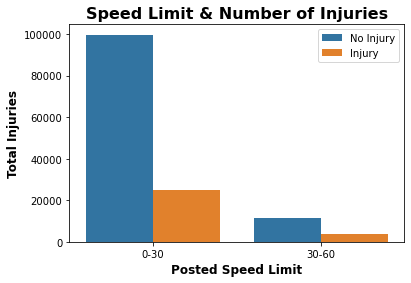

In [1239]:
sns.countplot(x='POSTED_SPEED_LIMIT', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Posted Speed Limit', weight= 'bold', size=12)
plt.title('Speed Limit & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

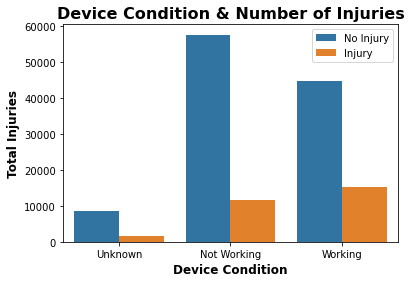

In [1241]:
sns.countplot(x='DEVICE_CONDITION', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Device Condition', weight= 'bold', size=12)
plt.title('Device Condition & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

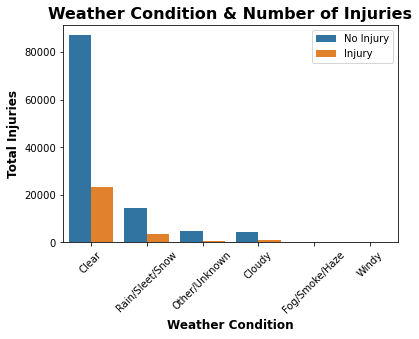

In [1243]:
sns.countplot(x='WEATHER_CONDITION', hue = 'INJURIES_TOTAL', data=merged2)
plt.xticks(rotation=45)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Weather Condition', weight= 'bold', size=12)
plt.title('Weather Condition & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

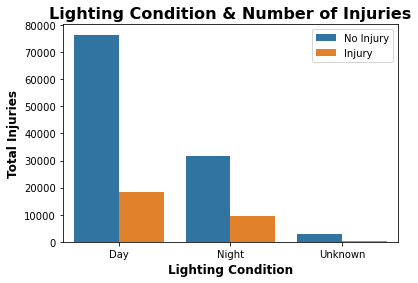

In [1244]:
sns.countplot(x='LIGHTING_CONDITION', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Lighting Condition', weight= 'bold', size=12)
plt.title('Lighting Condition & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

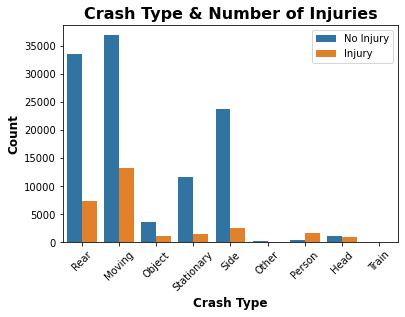

In [1347]:
sns.countplot(x='FIRST_CRASH_TYPE', hue = 'INJURIES_TOTAL', data=merged2)
plt.xticks(rotation=45)
plt.ylabel('Count', weight= 'bold', size=12)
plt.xlabel('Crash Type', weight= 'bold', size=12)
plt.title('Crash Type & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

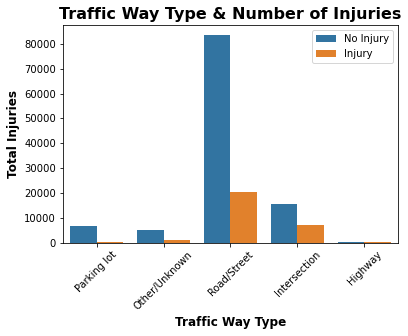

In [1248]:
sns.countplot(x='TRAFFICWAY_TYPE', hue = 'INJURIES_TOTAL', data=merged2)
plt.xticks(rotation=45)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Traffic Way Type', weight= 'bold', size=12)
plt.title('Traffic Way Type & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

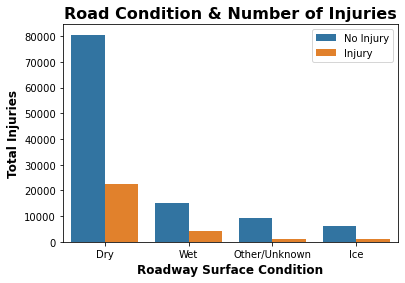

In [1249]:
sns.countplot(x='ROADWAY_SURFACE_COND', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Roadway Surface Condition', weight= 'bold', size=12)
plt.title('Road Condition & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

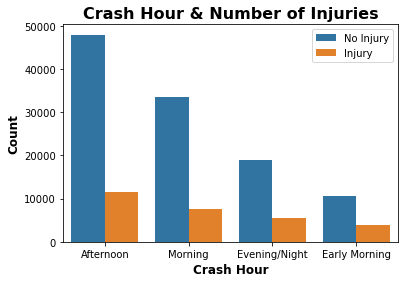

In [1346]:
sns.countplot(x='CRASH_HOUR', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Count', weight= 'bold', size=12)
plt.xlabel('Crash Hour', weight= 'bold', size=12)
plt.title('Crash Hour & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

In [1279]:
merged2.CRASH_HOUR.value_counts(normalize=True)

Afternoon        0.427246
Morning          0.293697
Evening/Night    0.175900
Early Morning    0.103157
Name: CRASH_HOUR, dtype: float64

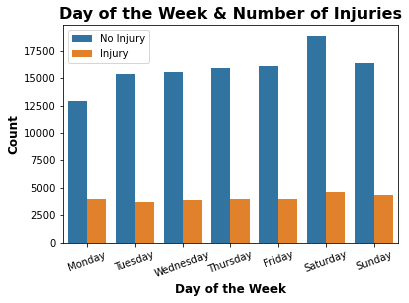

In [1345]:
sns.countplot(x='CRASH_DAY_OF_WEEK', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Count', weight= 'bold', size=12)
plt.xlabel('Day of the Week', weight= 'bold', size=12)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday',
                                            'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of the Week & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury'], loc=0)
plt.xticks(rotation=20);

In [1280]:
merged2.CRASH_DAY_OF_WEEK.value_counts(normalize=True)

6    0.168440
7    0.148404
5    0.144319
4    0.142520
3    0.138923
2    0.136623
1    0.120771
Name: CRASH_DAY_OF_WEEK, dtype: float64

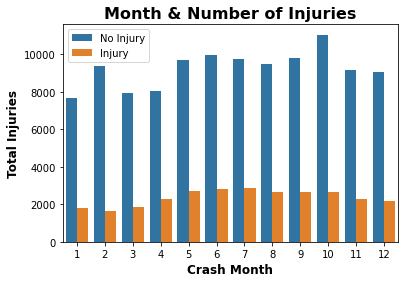

In [1254]:
sns.countplot(x='CRASH_MONTH', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Crash Month', weight= 'bold', size=12)
plt.title('Month & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

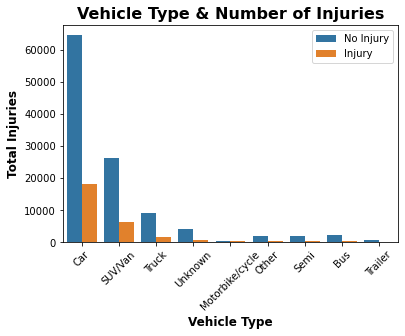

In [1256]:
sns.countplot(x='VEHICLE_TYPE', hue = 'INJURIES_TOTAL', data=merged2)
plt.xticks(rotation=45)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Vehicle Type', weight= 'bold', size=12)
plt.title('Vehicle Type & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

<AxesSubplot:xlabel='PERSON_TYPE', ylabel='count'>

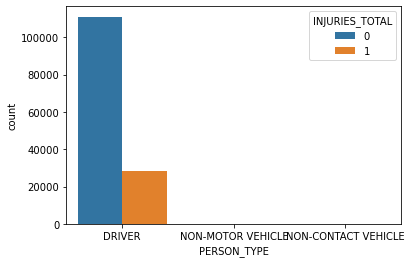

In [1155]:
sns.countplot(x='PERSON_TYPE', hue = 'INJURIES_TOTAL', data=merged2)

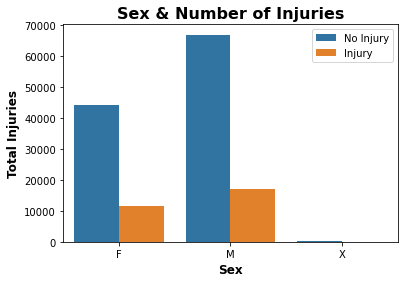

In [1257]:
sns.countplot(x='SEX', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Sex', weight= 'bold', size=12)
plt.title('Sex & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

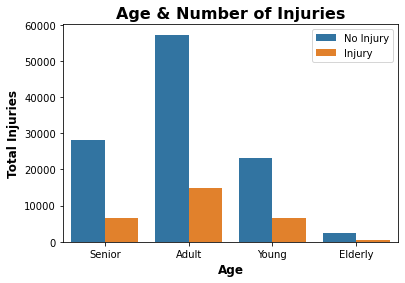

In [1258]:
sns.countplot(x='AGE', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Age', weight= 'bold', size=12)
plt.title('Age & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

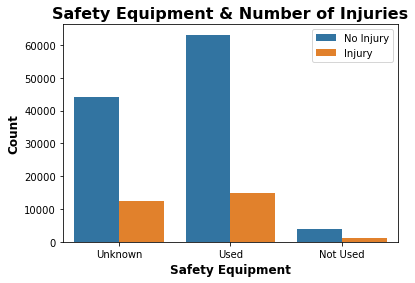

In [1348]:
sns.countplot(x='SAFETY_EQUIPMENT', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Count', weight= 'bold', size=12)
plt.xlabel('Safety Equipment', weight= 'bold', size=12)
plt.title('Safety Equipment & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

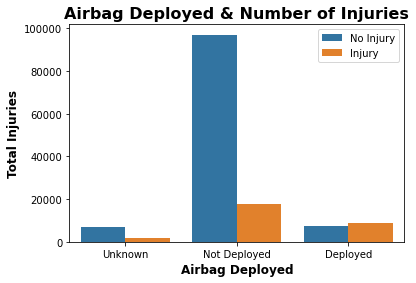

In [1260]:
sns.countplot(x='AIRBAG_DEPLOYED', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Airbag Deployed', weight= 'bold', size=12)
plt.title('Airbag Deployed & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

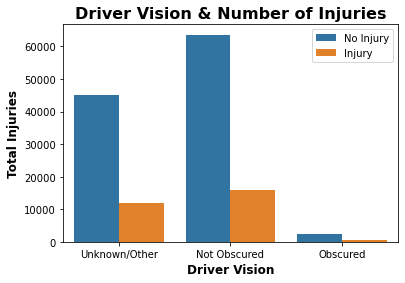

In [1262]:
sns.countplot(x='DRIVER_VISION', hue = 'INJURIES_TOTAL', data=merged2)
plt.ylabel('Total Injuries', weight= 'bold', size=12)
plt.xlabel('Driver Vision', weight= 'bold', size=12)
plt.title('Driver Vision & Number of Injuries', weight= 'bold', size=16)
plt.legend(['No Injury', 'Injury']);

In [1161]:
#after visual inspection is appears that PERSON_TYPE
# will not be helpful as it is so skewed and will be dropped

In [1162]:
merged2.drop('PERSON_TYPE', axis =1, inplace=True)

In [1163]:
merged2.head()

,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,INJURIES_TOTAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,VEHICLE_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,DRIVER_VISION
0,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0,Afternoon,3,7,Car,F,Senior,Unknown,Unknown,Unknown/Other
1,0-30,Unknown,Clear,Day,Rear,Parking lot,Dry,0,Afternoon,3,7,Car,F,Adult,Unknown,Unknown,Unknown/Other
9,0-30,Not Working,Clear,Day,Moving,Other/Unknown,Dry,0,Morning,7,12,Car,F,Adult,Unknown,Not Deployed,Not Obscured
33,30-60,Not Working,Clear,Night,Rear,Road/Street,Dry,0,Evening/Night,7,10,Car,M,Young,Used,Not Deployed,Not Obscured
34,30-60,Not Working,Clear,Night,Rear,Road/Street,Dry,0,Evening/Night,7,10,Car,M,Adult,Used,Not Deployed,Not Obscured


In [1164]:
merged2.duplicated().sum()

8

In [1165]:
merged2.drop_duplicates(keep='first', inplace=True)

In [1166]:
merged2.duplicated().sum()

0

In [1167]:
df = merged2

In [1168]:
df.shape

(139545, 17)

Text(0.5, 0, '')

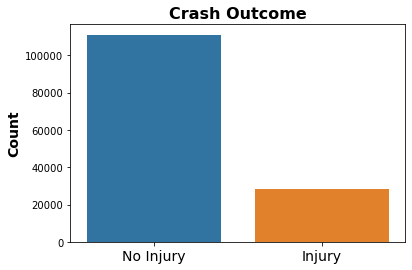

In [1344]:
sns.countplot(x='INJURIES_TOTAL', data=merged2)
plt.title("Crash Outcome", weight= 'bold', size=16)
plt.ylabel('Count',weight= 'bold', size=14)
plt.xticks([0,1], ['No Injury', 'Injury'], size=14)
plt.xlabel('')

***

# Begin Modeling 

## Setting up imports

In [1170]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, plot_roc_curve

### Scoring Function

In [1233]:
# from lecture, added roc curve

def scoring(estimator, X, y):
    '''
    Prints the accuracy, precision, and recall score of the given fitted estimator and data.

    Plots the confusion matrix and ROC/AUC.
    '''
    p_score = precision_score(y, estimator.predict(X))
    r_score = recall_score(y, estimator.predict(X)) 
    
    print(f'Accuracy: {estimator.score(X, y)}')
    print(f'Precision: {p_score}')
    print(f'Recall: {r_score}')
    
    plot_confusion_matrix(estimator, X, y)
    plot_roc_curve(estimator, X, y)

#### Train Test Split

In [1172]:
X = df.drop('INJURIES_TOTAL', axis=1)
y = df.INJURIES_TOTAL

In [1173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Set Up for Pipelines

In [1174]:
test = selector(dtype_include=object)

test(X)

['POSTED_SPEED_LIMIT',
 'DEVICE_CONDITION',
 'WEATHER_CONDITION',
 'LIGHTING_CONDITION',
 'FIRST_CRASH_TYPE',
 'TRAFFICWAY_TYPE',
 'ROADWAY_SURFACE_COND',
 'CRASH_HOUR',
 'VEHICLE_TYPE',
 'SEX',
 'AGE',
 'SAFETY_EQUIPMENT',
 'AIRBAG_DEPLOYED',
 'DRIVER_VISION']

In [1188]:
#creating mini-pipelines for ColumnTransformer: numeric and categorical

subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])


In [1189]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
     ('subpipe_cat', subpipe_cat, selector(dtype_include=object))], remainder='passthrough')

### Dummy Model

In [1190]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy='most_frequent'))
])


In [1191]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9088aa64f0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [1192]:
dummy_model_pipe.score(X_test, y_test)

0.7948806145555651

### First Simple Model

In [1193]:
logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

In [1194]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9088aa64f0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [1195]:
logreg_model_pipe.score(X_train, y_train)

0.8211985705822775

Accuracy: 0.8177544644136785
Precision: 0.6082474226804123
Recall: 0.3133035215204025


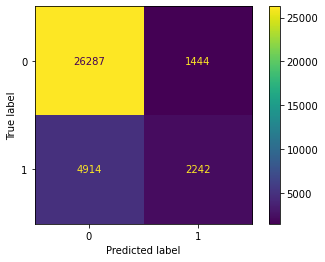

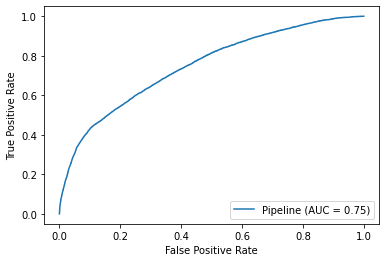

In [1196]:
scoring(logreg_model_pipe, X_test, y_test)

In [1197]:
f1_score(y_test, logreg_model_pipe.predict(X_test))

0.4135768308430179

In [1198]:
#model is not great...

### Random Forest Model

In [1199]:
rfc_model_pipe = Pipeline([('ct',CT),
                           ('rfc',RandomForestClassifier(random_state=42))
                          ])

In [1200]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9088aa64f0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [1201]:
rfc_model_pipe.score(X_train, y_train)

0.9780714326663992

In [1202]:
#model is overfit

Accuracy: 0.8047983489551982
Precision: 0.5379219640508549
Recall: 0.34292901062045833


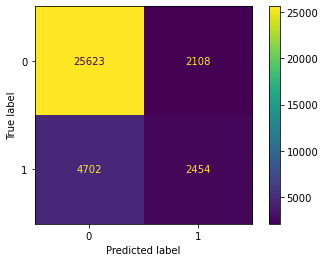

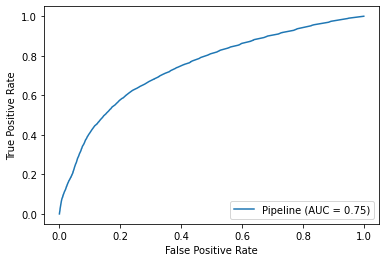

In [1203]:
scoring(rfc_model_pipe, X_test, y_test)

In [1204]:
f1_score(y_test, rfc_model_pipe.predict(X_test))

0.4188428059395801

In [1205]:
#about the same as logreg, but slightly worse

### Gradient Booster

In [1206]:
gbc = GradientBoostingClassifier(random_state=42)

gbc_model_pipe = Pipeline([('ct', CT), ('gbc',gbc)])

In [1207]:
gbc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9088aa64f0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [1208]:
gbc_model_pipe.score(X_train, y_train)

0.8236446329950887

Accuracy: 0.8198755983604208
Precision: 0.6238636363636364
Recall: 0.3068753493571828


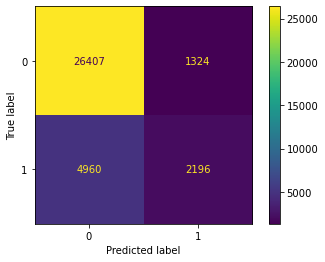

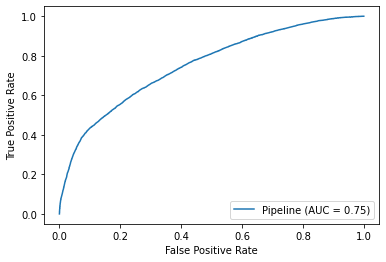

In [1209]:
scoring(gbc_model_pipe, X_test, y_test)

In [939]:
f1_score(y_test, gbc_model_pipe.predict(X_test))

0.40993788819875776

In [940]:
#model still has issues, will conduct grid search next.

***

## Grid Searching

For model tuning I am going to focus on the Gradient Booster model as it has the highest scores.

In [1210]:
gbc_model_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9088aa64f0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [ ]:
GradientBoostingClassifier()

In [1215]:
params = {}
params['gbc__learning_rate'] = [0.001, 0.01, 0.1]
params['gbc__n_estimators'] = [10, 100, 1000]
params['gbc__max_depth'] = [3, 7, 9]

In [1216]:
params

{'gbc__learning_rate': [0.001, 0.01, 0.1],
 'gbc__n_estimators': [10, 100, 1000],
 'gbc__max_depth': [3, 7, 9]}

In [1217]:
gs = GridSearchCV(gbc_model_pipe, params, cv=10, verbose=1, n_jobs=-1)

In [1218]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 166.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 267.6min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9088aa64f0>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_im

In [1219]:
gs.best_params_

{'gbc__learning_rate': 0.1, 'gbc__max_depth': 7, 'gbc__n_estimators': 1000}

In [1220]:
gs.score(X_train, y_train)

0.8965774236083243

In [1221]:
gs.score(X_test, y_test)

0.8346948720153639

## Final Model

Taking best parameters from grid search to make final model.

In [1225]:
final_model = Pipeline([
    ('ct', CT),
    ('gbc', GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=7,
                                       n_estimators=1000))])

In [1226]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9088aa64f0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [1227]:
final_model.score(X_train, y_train)

0.8965774236083243

Accuracy: 0.8346948720153639
Precision: 0.688160390138174
Recall: 0.35494689770821686


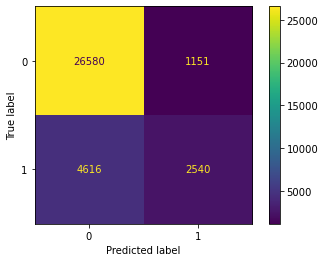

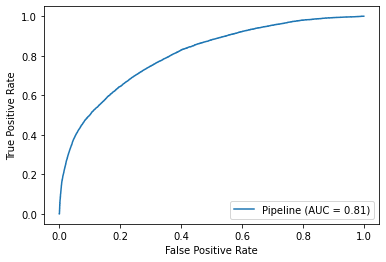

In [1229]:
scoring(final_model, X_test, y_test)

## Determining Feature Importance

In [1230]:
features = permutation_importance(final_model, X_test, y_test, n_repeats=30, random_state=42)

In [1231]:
#from sklearn documentation

for i in features.importances_mean.argsort()[::-1]:
     if features.importances_mean[i] - 2 * features.importances_std[i] > 0:
         print(f"{merged2.columns[i]:<8}"
               f"{features.importances_mean[i]:.3f}"
               f" +/- {features.importances_std[i]:.3f}")

SAFETY_EQUIPMENT0.049 +/- 0.001
FIRST_CRASH_TYPE0.033 +/- 0.001
CRASH_DAY_OF_WEEK0.019 +/- 0.001
CRASH_HOUR0.014 +/- 0.001
INJURIES_TOTAL0.013 +/- 0.001
ROADWAY_SURFACE_COND0.011 +/- 0.001
TRAFFICWAY_TYPE0.010 +/- 0.001
WEATHER_CONDITION0.010 +/- 0.001
DEVICE_CONDITION0.009 +/- 0.001
LIGHTING_CONDITION0.008 +/- 0.001
AGE     0.005 +/- 0.001
POSTED_SPEED_LIMIT0.004 +/- 0.000
CRASH_MONTH0.004 +/- 0.001
AIRBAG_DEPLOYED0.004 +/- 0.001
SEX     0.002 +/- 0.001
VEHICLE_TYPE0.002 +/- 0.000


In [1232]:
merged2.columns[0:4]

Index(['POSTED_SPEED_LIMIT', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION'],
      dtype='object')

## Conclusion 
Based on the features of importance I can reccomend the following to the Chicago Department of Transportaion:
1. Increase access to public transit: Due to the low number of collisions involving buses and trains the DOT and CTA need a strategy to make public transit an option for more people. Decreasing the number of personal vehicles on the road during commuter hours could lead to a decrease traffic incidents.
2. Safety initiatives: Since injuries are more likely to occur between a vehicle and cyclist safeguards should be made to protect them. The city should look into how to create more bike lanes and add protection from vehicles to the ones that already exist. Since safety equipment seems to be failing the city can have PSAs on how to correctly use personal and vehicle safety features such as seat belts and bike helmets
3. Targeted response windows: we now know that accidents resulting in injury occur in the  afternoons and Saturday. This information can be used by Chicago PD and emergency response systems for scheduling and resource allocation. 

## Next Steps
- Increase precision of model.
- These are only crashes that are documented through Chicago Police Department. Comparing records here to insurance claims might give a better idea of total crashes within the city limits. 
- Create a model that determines features most associated with severe injuries.
***